<a href="https://colab.research.google.com/github/jypaeng/Machine-Learning-Deployment/blob/master/third_molar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
import glob
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

print(" Title : 204명에서  ")

"""
난이도를 어떻게 나눌 수 있는 지가 관건이다. 
10분20분30분으로 임의로 구분하는 것이 의미가 있는가?

"""


#parameter
seed = 0
batch_size = 8
epoch = 200
w = 256
h = 256
test_size = 0.2
filters = (16,32,64)

#seed
np.random.seed(seed)
#tf.compat.v1.set_random_seed(seed)
tf.random.set_seed(seed)


#data source
main_dir = "/content/drive/My Drive/third_molar/"
data_dir = "/content/drive/My Drive/third_molar/third_molar_data_205.csv"
img_dir = "/content/drive/My Drive/third_molar/third_molar_images_flip_bright"

#print of parameter
print("\ndata : ",data_dir)
print("\nimage_folder :", img_dir)
print("\n")
print("seed=", seed)
print("batch_size = ", batch_size)
print("epoch =", epoch)
print("image_size = {0} X {1}".format(w,h))
print("test_size = ", test_size)
print("filters = ", filters)
print("\n")

#csv 읽어오기
df_org = pd.read_csv(data_dir)
df=df_org.copy()
print(df.head())
print(df.info())


#plt.title('Original age Histogram')
#sns.distplot(df['age'])

#plt.title('Original time_min Histogram')
#sns.distplot(df['time_min'])

#plt.title('Original mmo Histogram')
#sns.distplot(df['mmo'])

print(df.groupby("ext_tooth").count())
print(df.groupby("sex").count())
print(df.groupby("operator").count())


df["location"]=df["ext_tooth"].replace([38,48],[0,1])
df["location"].head(5)

#변환할 dictionary map을 만든다.
mapping = {
  'P':24,
  'K':38,
  'A':10,
  'Y':2,
  'D':1
  }
#dict.get()을 이용하여 변환 함수 생성
func=lambda x:mapping.get(x,x)

#df의 변수에 적용
df['experience'] = df.operator.map(func)

# 불필요한 col 삭제
df=df.drop(["no","date","ID","name","ext_tooth","no_root",
            "collagen_plug","stitch","bone_quality","winter_index",
            "pell_gregory_index",
            "experience","weight","height","Anesthesia"
               ,"difficulty_index"
            ],axis=1)

df_corr = df.drop(["operator"], axis=1)
corr = df.corr(method ='pearson')
print("\nCorrelation\n",corr)

#missing data의 visualization
#(1)
#import missingno as msno
#ax = msno.matrix(df)
#ax.get_figure().savefig("str")
#plt.show()
#(2)
#fig,ax = plt.subplots(figsize=(6,4))
#(1-df.isnull().mean()).abs().plot.bar(ax=ax)
#fig.savefig("", dpi=)
#plt.show()

#(3)
#ax=msno.bar(df)
#ax.get_figure().savefig("str")
#plt.show()

#
#ax=msno.heatmap(df,figsize=(6,6))
#ax.get_figure().savefig("str")
#plt.show()

#
#ax = msno.dendrogram(df)
#ax.get_figure().savefig("str")
#plt.show()

#imputing missing data
#from sklearn.impute import SimpleImputer
#im = SimpleImputer()
#imputed = im.fit_transform(df["bmi"])

# missing value를 평균 값으로 채운다. 
df = df.fillna(df.mean())
df["location"] = df["location"].astype(str)


print('\ndf.head()\n', df.head())

# operator에서 Y를 제거함. 
#df = df[df["operator"] != "Y"]
#print(df.head())

#범주형 변수의 hot-one encoding
df_ohe=pd.get_dummies(df)
print("\ndf_ohe.head()\n",df_ohe.head())
print("\ndf_ohe.info()",df_ohe.info())

#from sklearn.impute import SimpleImputer
#mean_imputer = SimpleImputer(strategy='mean')
#df_ohe = mean_imputer.fit_transform(df_ohe)

#= 이미지 파일 불러오기 ===================================
fname = os.listdir(img_dir)
fname = sorted(fname)
print(fname)

img_paths=[]
for i in fname:
    img_path=os.path.join(img_dir,i)
    img_paths.append(img_path)

from keras.preprocessing import image
img_paths.remove(img_dir + '/.DS_Store')  
img_paths.remove(img_dir + '/.ipynb_checkpoints')
images=[]
for i in img_paths:
    image = cv2.imread(i)
    image = cv2.resize(image, (w,h))
    images.append(image)

images = np.array(images)/255
#=============================================
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input, concatenate
from keras.utils import np_utils
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, Adagrad, RMSprop, Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
import locale

# MLP model =================================================================
def create_mlp(dim, regress=False):
    model = Sequential()
    model.add(Dense(16,
                    input_dim=dim,
                    kernel_regularizer=l2(0.001),      ##  0.001
                    activation="relu"))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation="relu"))

    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1))

    return model

#CNN model ===================================================================
def create_cnn(width, height, depth, filters=filters, regress=False):
    inputShape = (height, width, depth)
    chanDim = -1
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x) #initial : 16
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    if regress:
        x = Dense(1)(x)

    model = Model(inputs, x)
    return model



# clinical feature and target data preprocessing =====================================================================
#===================================================
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

def process_ahi_attributes(df, train, test):
	# initialize the column names of the continuous data
	# performin min-max scaling each continuous feature column to the range [0, 1]
	cs = MinMaxScaler()
	trainX = cs.fit_transform(train)
	testX = cs.transform(test)

	return (trainX, testX)
#===========================================================
split = train_test_split(df_ohe, images, test_size=test_size, random_state=42)  #original 42
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

maxahi = trainAttrX["time_min"].max()
trainY = trainAttrX["time_min"]/maxahi
testY = testAttrX["time_min"]/maxahi
print("\ntestY\n", testAttrX["time_min"])

trainAttrX = trainAttrX.drop(["time_min"],axis=1)
testAttrX = testAttrX.drop(["time_min"],axis=1)

print("\ntestAttrX\n",testAttrX)


(trainAttrX, testAttrX) = process_ahi_attributes(df_ohe, trainAttrX, testAttrX)


# 최종 모델 =====================================================

# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1])
cnn = create_cnn(w, h, 3)

# create the input to our final set of layers as the *output* of both the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1)(x)


model = Model(inputs=[mlp.input, cnn.input], outputs=x)

# 모델 compile ===============================================
adagrad1 = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(loss="mean_squared_error",
              optimizer=adagrad1,
              metrics=['mse'])


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 Title : 204명에서  

data :  /content/drive/My Drive/third_molar/third_molar_data_205.csv

image_folder : /content/drive/My Drive/third_molar/third_molar_images_flip_bright


seed= 0
batch_size =  8
epoch = 200
image_size = 256 X 256
test_size =  0.2
filters =  (16, 32, 64)


   no operator        date        ID  ... height weight       bmi  Anesthesia
0   1        A  2020.03.05  25132686  ...    NaN    NaN       NaN           0
1   2        A  2020.03.06  43936178  ...  178.0   72.0  22.72440           0
2   3        A  2020.03.06  43557920  ...  175.0   71.0  23.18367           0
3   4        A  2020.03.06  43915276  ...  165.0   62.0  22.77319           0
4   5        K  2020.03.06  24816372  ...  185.0  105.0  30.67933           0

[5 rows x 21 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   no                  204 no

Using TensorFlow backend.



testY
 15      8
9       6
115    15
78      6
66      7
45     11
132    10
161    15
201    10
181    25
69     20
163    13
167    15
152     6
56     20
191     9
18     12
79     12
55     11
146     5
177    26
97     17
95     17
30      5
127     7
16     14
174     9
86     14
135    20
124    15
65      8
68     20
128    50
67     15
76     16
100    11
140     5
138     9
144    16
84     13
82     20
Name: time_min, dtype: int64

testAttrX
      age  mmo        bmi  operator_A  ...  sex_F  sex_M  location_0  location_1
15    38   43  20.571430           1  ...      0      1           0           1
9     30   42  17.444930           1  ...      1      0           1           0
115   17   42  29.394690           0  ...      1      0           0           1
78    27   42  18.670930           1  ...      1      0           0           1
66    54   42  24.508950           0  ...      0      1           0           1
45    38   50  25.469390           1  ...      0      1      

[INFO] training model...
Train on 163 samples, validate on 41 samples
Epoch 1/200
 - 1s - loss: 0.0132 - mse: 0.0092 - val_loss: 0.0185 - val_mse: 0.0145
Epoch 2/200
 - 1s - loss: 0.0135 - mse: 0.0095 - val_loss: 0.0216 - val_mse: 0.0176
Epoch 3/200
 - 1s - loss: 0.0122 - mse: 0.0082 - val_loss: 0.0222 - val_mse: 0.0182
Epoch 4/200
 - 1s - loss: 0.0131 - mse: 0.0091 - val_loss: 0.0223 - val_mse: 0.0183
Epoch 5/200
 - 1s - loss: 0.0150 - mse: 0.0110 - val_loss: 0.0221 - val_mse: 0.0181
Epoch 6/200
 - 1s - loss: 0.0120 - mse: 0.0080 - val_loss: 0.0218 - val_mse: 0.0178
Epoch 7/200
 - 1s - loss: 0.0131 - mse: 0.0092 - val_loss: 0.0215 - val_mse: 0.0175
Epoch 8/200
 - 1s - loss: 0.0131 - mse: 0.0092 - val_loss: 0.0223 - val_mse: 0.0184
Epoch 9/200
 - 1s - loss: 0.0111 - mse: 0.0072 - val_loss: 0.0215 - val_mse: 0.0176
Epoch 10/200
 - 1s - loss: 0.0138 - mse: 0.0098 - val_loss: 0.0195 - val_mse: 0.0156
Epoch 11/200
 - 1s - loss: 0.0107 - mse: 0.0068 - val_loss: 0.0197 - val_mse: 0.0158
Epoc

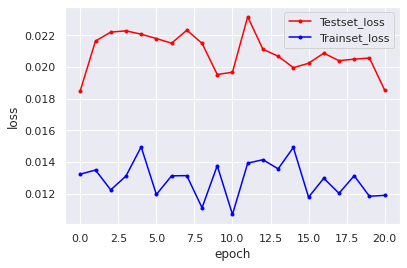



    real time  predicted time
0         8.0       12.304491
1         6.0        6.020712
2        15.0        8.453866
3         6.0       11.238209
4         7.0        5.600073
5        11.0       12.088326
6        10.0        9.906610
7        15.0       18.057941
8        10.0       12.328972
9        25.0       21.651546
10       20.0       18.285027
11       13.0        9.641350
12       15.0       29.256367
13        6.0        9.688136
14       20.0       15.525295
15        9.0        5.600073
16       12.0       11.205628
17       12.0        9.007224
18       11.0       10.727742
19        5.0        9.058081
20       26.0       10.051966
21       17.0       13.653840
22       17.0       13.448580
23        5.0       11.355037
24        7.0        6.840548
25       14.0       11.567140
26        9.0       12.237485
27       14.0       14.273737
28       20.0       15.390931
29       15.0       12.452038
30        8.0       11.827566
31       20.0       26.346100
32      

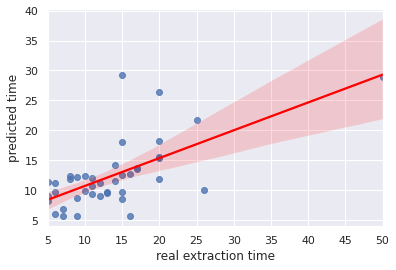

In [4]:
import datetime

date_time = datetime.datetime.now().strftime('%y%m%d_%H%M%S')
date = datetime.datetime.now().strftime('%y%m%d')

print("[INFO] training model...")
callbacks = [EarlyStopping(monitor="val_loss", patience = 20),
                  ModelCheckpoint(filepath = main_dir + "result/best_model_{0}.h5".format(date_time)
              , monitor="val_loss",
              save_best_only=True)
              ]
history = model.fit([trainAttrX,trainImagesX], trainY,
                    validation_data=([testAttrX,testImagesX],testY),
                    epochs= epoch,
                    batch_size = batch_size,
                    verbose = 2
                    ,callbacks=callbacks
                    )

# loss curve ==========================================================
import matplotlib.pyplot as plt

y_loss = history.history['loss']
y_vloss = history.history['val_loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len,y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len,y_loss, marker='.', c='blue', label='Trainset_loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(main_dir + "result/loss_curve_{0}.jpg".format(date_time), dpi=300)
plt.show()

# mse curve  ============================================================
# y_mse = history.history['mse']
#  #test set loss
# y_vmse = history.history['val_mse']
#
# x_len = np.arange(len(y_mse))
# plt.plot(x_len,y_vmse, marker='.', c='red', label='Testset_mse')
# plt.plot(x_len,y_mse, marker='.', c='blue', label='Trainset_mse')
# plt.legend(loc='upper right')
# plt.xlabel('epoch')
# plt.ylabel('mse')
# plt.show()

#==============================================================
#test set에서 prediction
Y = model.predict([testAttrX,testImagesX])*maxahi # Y= predicted ahi
X = testY*maxahi # X = real ahi

pd.set_option('display.max_rows',100)

X1 = X.tolist()
Y1 = Y.flatten()

predicted_ahi_df = pd.DataFrame()
predicted_ahi_df['real time'] = X1
predicted_ahi_df['predicted time'] = Y1
print("\n")
print(predicted_ahi_df)
print("\n")

## 결과 분석 =================================================
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y1)

mse = mean_squared_error(X,Y1)
rmse=np.sqrt(mse)
r2_score = r2_score(X,Y1)
mae = mean_absolute_error(X,Y1)

print('r            = ',r_value)
print('r2           = ', r2_score)
print("r-squared    = ", r_value**2)
print('p-value      = ',p_value)
print('rmse         = ',rmse)
print("mae          = ", mae)
print('standard error : ',std_err)
print('slope        = ', slope)
print('intercept    = ', intercept)
#=====================================
import datetime
import os

from scipy import stats
tTestResult = stats.ttest_rel(Y1, X)

f = open(main_dir + "result/result_{0}.txt".format(date_time), 'w')
parameter = "image = {0}X{1}\ntest_size = {2}".format(w,h,test_size)
result = "\nr = {0}\nr2 = {1}\nrmse = {2}\nmae = {3}\npaired t-test p-value = {4}".format(r_value,
                                                                                          r2_score,
                                                                                        rmse,
                                                                                        mae,tTestResult[1])
model_file = "\nmodel_file = best_model_{0}.h5".format(date_time)
f.write(parameter)
f.write(result)
f.write(model_file)
f.close()


basename = "result"
date_time = datetime.datetime.now().strftime('%y%m%d_%H%M%S')
date = datetime.datetime.now().strftime('%y%m%d')
result_dir = "/Users/paengmacbookpro13/Dropbox/python/third_molar/result"
#if result_dir == False:
#    os.mkdir("/Users/paengmacbookpro13/Dropbox/python/third_molar/{0}".format(date))

filename = '_'.join([basename,date_time,str(batch_size)])
print(filename)

import seaborn as sns
sns.set(color_codes=True)
x, y = pd.Series(X, name="real extraction time"), pd.Series(Y1, name="predicted time")
ax = sns.regplot(x=x,y=y, line_kws={'color':'red'},label='r = {0}'.format(r_value))
plt.savefig(main_dir + "result/prediction_{0}.jpg".format(date_time), dpi=300)
#plt.legend(show=True, borderpad = 1)
plt.show()